In [10]:
import numpy as np
import torch
from transformers import Wav2Vec2Model, Wav2Vec2FeatureExtractor
from datasets import load_dataset
from IPython.display import Audio, display

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Data

In [2]:
class CommonVoiceDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        audio_array = self.dataset[idx]['audio']['array']
        sampling_rate = self.dataset[idx]['audio']['sampling_rate']
        sentence = self.dataset[idx]['sentence']

        audio_tensor = torch.tensor(audio_array).float()
        return audio_tensor, sampling_rate, sentence

In [4]:
# Load dataset
dataset = load_dataset("mozilla-foundation/common_voice_11_0", "pt", split='train')
train_dataset = CommonVoiceDataset(dataset)

Found cached dataset common_voice_11_0 (/export/home/lium/bdos/.cache/huggingface/datasets/mozilla-foundation___common_voice_11_0/pt/11.0.0/3f27acf10f303eac5b6fbbbe02495aeddb46ecffdb0a2fe3507fcfbf89094631)


In [6]:
# Take one example from training set and get its embeddings
audio_tensor, sampling_rate, sentence = train_dataset[0]
print("Text:", sentence)
display(Audio(audio_tensor.numpy(), rate=sampling_rate))

Text: Antônio Torquato


## Model

In [3]:
# Load pretrained model and feature extractor
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-xls-r-300m")
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-xls-r-300m")

Some weights of the model checkpoint at facebook/wav2vec2-xls-r-300m were not used when initializing Wav2Vec2Model: ['quantizer.codevectors', 'project_q.bias', 'project_hid.weight', 'project_hid.bias', 'quantizer.weight_proj.weight', 'quantizer.weight_proj.bias', 'project_q.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
inputs = feature_extractor(audio_tensor.numpy(), return_tensors="pt", sampling_rate=16000)

In [8]:
# Compute the embeddings
with torch.no_grad():
    embeddings = model(**inputs).last_hidden_state

In [9]:
print(embeddings.shape)

torch.Size([1, 480, 1024])


## Visualization

In [11]:
# Assuming 'embeddings' is the output from your model
embeddings_reshaped = embeddings.squeeze(0) # Now the shape is (480, 1024)

In [12]:
# Create a PCA object
pca = PCA(n_components=3) # We're reducing dimensionality to 3

In [13]:
# Fit and transform the data
pca_result = pca.fit_transform(embeddings_reshaped)

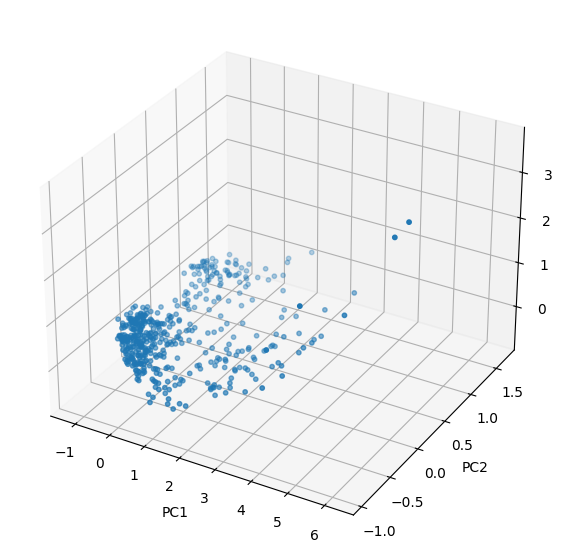

In [14]:
# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")

# Adding points on the 3D plot
ax.scatter3D(pca_result[:,0], pca_result[:,1], pca_result[:,2], s=10)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()